In [85]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import scipy as sp
import autograd.numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

from utils.models import BNN, BNN_LV
from utils.functions import gaussian, log_gaussian
from utils.training import HMC
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.plot import plot_posterior_predictive


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in some previous HMC sample results and initial data etc.


In [23]:
# Data Loading
y_hsc, X_hsc = generate_regression_outputs(type='hsc')

# BNN
# Parameters
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[5],
             'biases' : [1,1],
             'activations' : ['relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}
bnn_lv = BNN_LV(architecture=architecture)

# HMC Sampler
hmc = HMC(log_target_func=None, position_init=np.zeros(bnn_lv.get_weights().shape), total_samples=1000, leapfrog_steps=50, step_size=1e-4,
    burn_in=0.5, thinning_factor=1, mass=1.0, random_seed=207, progress=False)

hmc.load_state(filepath='../data/hmc/heteroscedastic_run1.json')

Loaded HMC state : ../data/hmc/heteroscedastic_run1.json .


## Plot Predictive Uncertainty

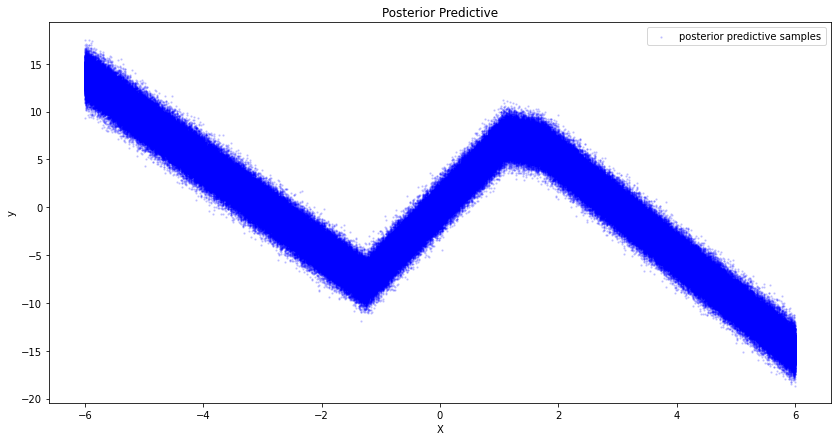

In [83]:
x_test_space = np.linspace(-6, 6, 1000)
w_random_samples = hmc.samples[np.random.choice(hmc.samples.shape[0], 1000), :]

ax = plot_posterior_predictive(x_test_space, bnn_lv, w_random_samples, mode='points', real_x=X_hsc, real_y=y_hsc)
ax.legend()
ax.set_title("Posterior Predictive")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.show()

## Entropy Calculations

To distinguish between the epistemic and aleatoric uncertainties, we require a method to decompose where the uncertainties are being introduced - either the 
uncertainties across the weights (epistemic) or the uncertainty inherent within the noise of the data (aleatoric). 

In the original Depeweg paper this is performed in two ways, via Entropy and via variance. Focusing first on entropy, the entropy of a set of points represent how
much inherent variation exists. Formally this can be calculated using the functional pdf, but in this case where our BNN+LV posterior is not a known form, we must use
an approximate technique such as K-Nearest Neighbor.

Using KNN as an approximate Entropy calculation goes back to the paper by Kozachenko & Leonenko (1987) (http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=ppi&paperid=797&option_lang=eng)
although is more succinctly stated in a later paper by Singh et al. (https://www.tandfonline.com/doi/pdf/10.1080/01966324.2003.10737616?needAccess=true) (Eqn. 4)

This KNN approximation of the Entropy is stated as:
$$ 
\hat{H}_n = \frac{p}{n}\sum_{i=1}^n ln(p_i) + ln\left[ \frac{\pi^{p/2}}{\Gamma(\frac{p}{2} + 1)} \right] + \gamma + ln(n-1)
$$

Where:
$$ 
p = \text{dimensionality} \quad n = \text{number of data points} \quad p_i = \text{distance to nearest neighbor} \quad \gamma = \text{Euler constant}
$$

So in essence the entropy is the average of the natural log of the distance from each point to its closest neighbour, scaled by the size and dimensionality of the
problem at hand. The additional constants are related to the surface area of a hypersphere in $p$ dimensions and scales the entropy based on the overall size of 
the hypersphere within which the entropy is being calculated. 

With a method for approximating the Entropy of a given set of data, we must then apply this to the BNN+LV in order to decompose the uncertainty. Naively applying 
the entropy calculation across the outputs of the BNN+LV however will not give us anything more than the overall uncertainty, including both aleatoric and epistemic.
To decompose this we need to calculate two entropies, the overall entropy and the entropy which occurs due to the uncertainty over the weights (epistemic uncertainty).
The difference of which leaves just the aleatoric uncertainty.

The formulation given in the paper for this decomposition is:
$$
\text{Overall uncertainty} = H(y*|x*)
$$
$$
\text{Epistemic uncertainty} = \mathbb{E}_{q(W)}[H(y*|W,x*)]
$$
$$
\text{Aleatoric uncertainty} = H(y*|x*) - \mathbb{E}_{q(W)}[H(y*|W,x*)]
$$

Being unable to calculate the entropies exactly though, we instead substitute in our approximation for the entropy, $\hat{H}(.)$ and calculate it as follows:
$$
\text{Overall uncertainty} = \hat{H}(y*^1,...,y*^L)
$$
$$
\text{Epistemic uncertainty} = \frac{1}{M} \sum_{i=1}^M \hat{H}(y*^{1,W_i}, ..., y*^{L,W_i})
$$
$$
\text{Aleatoric uncertainty} = \hat{H}(y*^1,...,y*^L) - \frac{1}{M} \sum_{i=1}^M \hat{H}(y*^{1,W_i}, ..., y*^{L,W_i})
$$

In words this means using the KNN formula to calculate the overall entropy of a given set of output data points, $y*$ from the model and then separately calculating
the average of the entropy across many different models through repeated sampling of the weights. This second average term should represent the uncertainty which is
introduced by the variations across model (aka the differences, aka the uncertainties, of the true weight parameters).

In [104]:
## Ent
p = 100
np.log( (np.pi ** (p/2)) / sp.special.gamma((p/2) + 1) )

-91.24127265930302

## Entropy Dimensionality Testing

One of the problems with the entropy calculation using KNN is that it is only an approximation to the true value of the entropy and the very concept of nearest
neighbor algorithms has been questioned in high dimensions (https://arxiv.org/pdf/1110.4347.pdf). To understand how this might effect the decomposition of uncertainty
we wished to explore how the KNN entropy approximation is affected as the number of dimensions increases.

To do so we will utilize a simple Gaussian normal, sampling points in increasing numbers of dimensions but otherwise keeping all parameters equal, and observe how the
entropy calculation changes.